In [1]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet
import cycler
import skyproj
import healpy as hp
import rubin_sim.maf as maf

In [2]:
summaries = maf.get_metric_summaries(summary_source='summary.h5')

In [3]:
metric_sets = maf.get_metric_sets('metric_sets.json')
metric_sets.groupby('metric set').first().index

Index(['AGN N QSO', 'AGN SF', 'AGN SF DDF', 'AGN TimeLag 100 days DDF',
       'AGN TimeLag 5 days DDF', 'AGN short', 'AGN timelag', 'DDF Cadence',
       'DDF Depths', 'DESC WFD', 'GP filters', 'GP footprint', 'GP season',
       'GP visit', 'Local Volume', 'N Visits', 'SCOC', 'SL IQ', 'SL TDC',
       'SNIa DDF', 'SNSL DDF', 'SRD', 'SSO N Objs', 'SSO discovery',
       'SSO discovery options', 'SSO fraction 3 bands', 'SSO fraction 4 bands',
       'SSO fraction 5 bands', 'SSO fraction 6 bands',
       'SSO lightcurve inversion', 'Stars', 'TVS Gaps', 'TVS KNe',
       'TVS KNe short', 'TVS PeriodModulation', 'TVS PeriodicDetect',
       'TVS Presto', 'TVS TDE', 'TVS XRB', 'TVS anomalies',
       'TVS microlensing all', 'TVS microlensing short', 'TVS short',
       'WFD Depths', 'cadence', 'galaxies', 'plot areas', 'radar',
       'short description'],
      dtype='object', name='metric set')

In [4]:
blob_long_metrics = [c for c in summaries if 'long' in c and "solar" not in c and 'Count' in c]

first_gr = [c for c in summaries if "blob_long" in c and "Count" in c and "gr" in c]
first_ri = [c for c in summaries if "blob_long" in c and "Count" in c and "ri" in c]
first_iz = [c for c in summaries if "blob_long" in c and "Count" in c and "iz" in c]
all_first = [c for c in summaries if "blob_long" in c and "Count" in c]

triplets = summaries[blob_long_metrics].sum(axis=1)
summaries['all_triplets'] = triplets
summaries['late_triple'] = summaries[['Identity Counts_long UniSlicer']].sum(axis=1)
summaries['first_gr'] = summaries[first_gr].sum(axis=1)
summaries['first_ri'] = summaries[first_ri].sum(axis=1)
summaries['first_iz'] = summaries[first_iz].sum(axis=1)
summaries['pair_long'] = summaries[all_first].sum(axis=1)
print(blob_long_metrics)

['Identity Counts_blob_long, gr, a UniSlicer', 'Identity Counts_blob_long, gr, b UniSlicer', 'Identity Counts_blob_long, iz, a UniSlicer', 'Identity Counts_blob_long, iz, b UniSlicer', 'Identity Counts_blob_long, ri, a UniSlicer', 'Identity Counts_blob_long, ri, b UniSlicer', 'Identity Counts_long UniSlicer']


In [5]:
counts = [c for c in summaries if "Nvisits" in c and "UniSlicer" in c]

In [6]:
runs = ['baseline_v3.3_10yrs', 'baseline_v3.4_10yrs']
runs += [r for r in summaries.index if "roll_uniform" in r]

In [7]:
weather = [r for r in summaries.index if "weather" in r]
dev = np.std(summaries.loc[weather], axis=0)

In [8]:
def plot_run_metric_uncert(
    summary,
    uncertainty,
    run_label_map=None,
    metric_label_map=None,
    metric_set=None,
    cmap=None,
    linestyles=['-'],
    markers=["."],
    sep_plots=True,
    ax=None
):
    """Plot normalized metric values as colored points on a cartesian plane.

    Parameters
    ----------
    summary : `pandas.DataFrame`
        Values to be plotted. Should only include runs and metrics that
        should actually appear on the plot.
    uncertainty : `pandas.DataFrame`
        Uncertainty values to plot on each data point. Should match summary metric columns.
    run_label_map : mapping
        A python `mapping` between canonical run names and run labels as they
        should appear on plot labels. Use of this option is discouraged, because
        it makes it harder to match plots to data.
        run_label_map could be created by archive.get_runs().loc[these_runs]['brief']
    metric_label_map : mapping
        A python `mapping` between canonical metric names and metric labels
        as they should appear on plot labels. Use this option carefully, because
        it makes it harder to match plots to metric calculation code..
        metric_label_map could be equivalent to metric_set['short_name']
    metric_set : `pandas.DataFrame`
        Metric metadata as returned by `archive.get_metric_sets`
    ax : `matplotlib.axes.Axes`
        The axes on which to plot the data.
    cmap : `matplotlib.colors.ColorMap`
        The color map to use for point colors.
    linestyles : `list`
        A list of matplotlib linestyles to use to connect the lines
    markers : `list`, opt
        A list of matplotlib markers to use to represent the points

    Returns
    -------
    fig : `matplotlib.figure.Figure`
        The plot figure.
    ax : `matplotilb.axes.Axes`
        The plot axes.


    The run order and metric order (imposed into the summary dataframe passed here as `summary`)
    are important and preserved in the plot. These should be set in the (subset) `summary` dataframe
    passed here; the metric_set is available, but used for 'invert' and plot styling and alternate labels.
    """

    # If the metric sets we are passed has a multilevel index,
    # get rid of the levels we do not need.
    if metric_set is not None and metric_set.index.nlevels > 1:
        extra_levels = list(set(metric_set.index.names) - set(["metric"]))
        metric_set = metric_set.droplevel(extra_levels).groupby(level="metric").first()

    # Pull original order for metric & runs from summary
    run_order = summary.index.values
    metric_order = summary.columns.values
    if run_label_map is not None:
        run_order = [run_label_map[r] for r in run_order]
    if metric_label_map is not None:
        metric_order = [metric_label_map[m] for m in metric_order]

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    else:
        fig = ax.get_figure()


    if cmap is None:
        cmap = colorcet.glasbey_hv
        cmap_default = True
    else:
        cmap_default = False
    # make the linestyles and symbols list the same length as cmap, for cycler
    try:
        num_colors = len(cmap)
        colors = cmap
    except TypeError:
        num_colors = len(cmap.colors)
        colors = cmap.colors
    ls_grow = int(np.ceil(num_colors / len(linestyles)))
    linestyles = (list(linestyles) * ls_grow)[:num_colors]
    marker_grow = int(np.ceil(num_colors / len(markers)))
    markers = (list(markers) * marker_grow)[:num_colors]

    # But use styles from metric_set if available
    if metric_set is not None:
        for i, m in enumerate(summary):
            if m in metric_set.index:
                style = metric_set.loc[m, 'style']
                if len(style) > 1:
                    ci = style[0]
                    # Let user specify color map for override
                    if cmap_default:
                        colors[i] = ci
                    li = style[1]
                    linestyles[i] = li
                else:
                    li = style[0:]
                    linestyles[i] = li
    
    ax.set_prop_cycle(
        cycler.cycler(color=colors) + cycler.cycler(linestyle=linestyles) + cycler.cycler(marker=markers)
    )
   
    
    for i, m in enumerate(summary):
        # new plots for each metric? 
        if sep_plots and i>0:
            fig, ax = plt.subplots(figsize=(10, 6))
            cc = [colors[i]]
            ax.set_prop_cycle(cycler.cycler(color=cc) + cycler.cycler(linestyle=linestyles[i]) + cycler.cycler(marker=markers[i]))
        if metric_label_map is not None:
            label = metric_label_map[m]
        else:
            label = m
        ax.errorbar(run_order, summary[m],
                    yerr=uncertainty[m],
                    label=label) 
        ax.set_ylabel(label, fontsize='large')
        if sep_plots:
            if metric_set is not None:
                if m in metric_set.index:
                    if metric_set.loc[m, 'invert']:
                        ax.invert_yaxis()
            ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
            ax.grid(True, alpha=0.5)
            ax.legend()
            
    if not sep_plots:
        ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
        ax.grid(True, alpha=0.5)
        ax.legend(bbox_to_anchor=(1.0, 1.0))
    
    return fig, ax

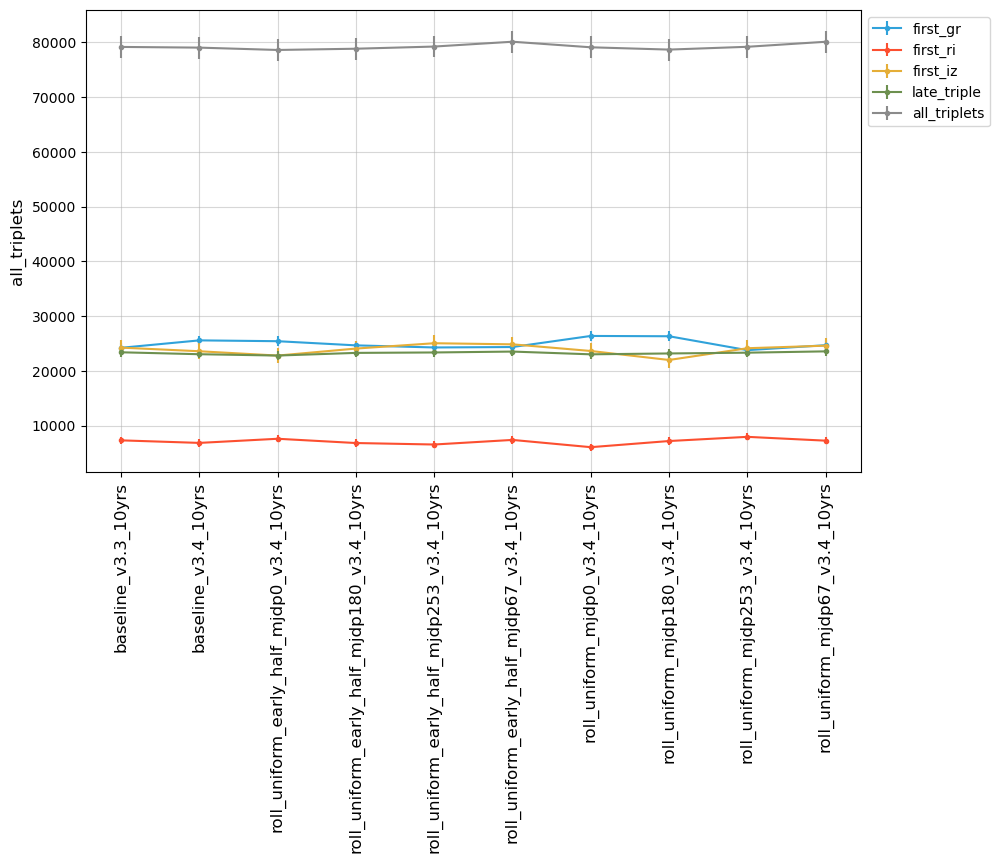

In [9]:
metrics = ['first_gr', 'first_ri', 'first_iz', 'late_triple', 'all_triplets']
fig, ax = plot_run_metric_uncert(
    summaries.loc[runs, metrics], #- summaries.loc['baseline_v3.0_10yrs', metrics],
    dev[metrics],
    cmap=None,
    linestyles=['-'],
    markers=["."],
    sep_plots=False
)

In [10]:
summaries.loc[runs, metrics]# summaries.loc['baseline_v3.0_10yrs', metrics]

metric                                      first_gr  first_ri  first_iz  \
run                                                                        
baseline_v3.3_10yrs                          24217.0    7310.0   24251.0   
baseline_v3.4_10yrs                          25573.0    6845.0   23587.0   
roll_uniform_early_half_mjdp0_v3.4_10yrs     25422.0    7601.0   22797.0   
roll_uniform_early_half_mjdp180_v3.4_10yrs   24662.0    6822.0   24077.0   
roll_uniform_early_half_mjdp253_v3.4_10yrs   24278.0    6551.0   25051.0   
roll_uniform_early_half_mjdp67_v3.4_10yrs    24357.0    7390.0   24851.0   
roll_uniform_mjdp0_v3.4_10yrs                26382.0    6065.0   23636.0   
roll_uniform_mjdp180_v3.4_10yrs              26327.0    7187.0   21991.0   
roll_uniform_mjdp253_v3.4_10yrs              23785.0    7952.0   24139.0   
roll_uniform_mjdp67_v3.4_10yrs               24693.0    7254.0   24606.0   

metric                                      late_triple  all_triplets  
run                                                                    
baseline_v3.3_10yrs                             23397.0       79175.0  
baseline_v3.4_10yrs                             23044.0       79049.0  
roll_uniform_early_half_mjdp0_v3.4_10yrs        22801.0       78621.0  
roll_uniform_early_half_mjdp180_v3.4_10yrs      23287.0       78848.0  
roll_uniform_early_half_mjdp253_v3.4_10yrs      23365.0       79245.0  
roll_uniform_early_half_mjdp67_v3.4_10yrs       23528.0       80126.0  
roll_uniform_mjdp0_v3.4_10yrs                   23026.0       79109.0  
roll_uniform_mjdp180_v3.4_10yrs                 23184.0       78689.0  
roll_uniform_mjdp253_v3.4_10yrs                 23325.0       79201.0  
roll_uniform_mjdp67_v3.4_10yrs                  23566.0       80119.0

In [11]:
summaries.loc[runs, metric_sets.loc['DESC WFD']['metric']]

metric                                      Median Exgalm5WithCuts i band non-DD year 10 HealpixSlicer  \
run                                                                                                      
baseline_v3.3_10yrs                                                                 26.391883            
baseline_v3.4_10yrs                                                                 26.397033            
roll_uniform_early_half_mjdp0_v3.4_10yrs                                            26.397190            
roll_uniform_early_half_mjdp180_v3.4_10yrs                                          26.381210            
roll_uniform_early_half_mjdp253_v3.4_10yrs                                          26.404610            
roll_uniform_early_half_mjdp67_v3.4_10yrs                                           26.387944            
roll_uniform_mjdp0_v3.4_10yrs                                                       26.403275            
roll_uniform_mjdp180_v3.4_10yrs                                                     26.373115            
roll_uniform_mjdp253_v3.4_10yrs                                                     26.401536            
roll_uniform_mjdp67_v3.4_10yrs                                                      26.388747            

metric                                      Rms Exgalm5WithCuts i band non-DD year 10 HealpixSlicer  \
run                                                                                                   
baseline_v3.3_10yrs                                                                  0.150735         
baseline_v3.4_10yrs                                                                  0.149678         
roll_uniform_early_half_mjdp0_v3.4_10yrs                                             0.145604         
roll_uniform_early_half_mjdp180_v3.4_10yrs                                           0.149403         
roll_uniform_early_half_mjdp253_v3.4_10yrs                                           0.150792         
roll_uniform_early_half_mjdp67_v3.4_10yrs                                            0.147681         
roll_uniform_mjdp0_v3.4_10yrs                                                        0.148972         
roll_uniform_mjdp180_v3.4_10yrs                                                      0.152503         
roll_uniform_mjdp253_v3.4_10yrs                                                      0.150660         
roll_uniform_mjdp67_v3.4_10yrs                                                       0.150837         

metric                                      Effective Area (deg) Exgalm5WithCuts i band non-DD year 10 HealpixSlicer  \
run                                                                                                                    
baseline_v3.3_10yrs                                                              17775.400112                          
baseline_v3.4_10yrs                                                              17762.810707                          
roll_uniform_early_half_mjdp0_v3.4_10yrs                                         17772.042937                          
roll_uniform_early_half_mjdp180_v3.4_10yrs                                       17736.792604                          
roll_uniform_early_half_mjdp253_v3.4_10yrs                                       17747.703422                          
roll_uniform_early_half_mjdp67_v3.4_10yrs                                        17765.328588                          
roll_uniform_mjdp0_v3.4_10yrs                                                    17725.881787                          
roll_uniform_mjdp180_v3.4_10yrs                                                  17770.364350                          
roll_uniform_mjdp253_v3.4_10yrs                                                  17786.310929                          
roll_uniform_mjdp67_v3.4_10yrs                                                   17751.060596                          

metric                                      3x2pt

In [12]:
# Number of visits per season, per point on the sky - distinguish between high and low rolling seasons, find averages


In [14]:
from astropy.time import Time
from astropy.coordinates import get_sun
from astropy.coordinates import EarthLocation

from rubin_scheduler.utils import survey_start_mjd

RUBIN_LOC = EarthLocation.of_site("Cerro Pachon")

MJD_2024 = Time(
    "2024-01-01T00:00:00.00",
    format="isot",
    scale="utc",
    location=RUBIN_LOC,
).utc.mjd

YEAR = 365.25
BASELINE_SURVEY_START_MJD = survey_start_mjd() # 60796 = May 10, 2025


def get_sun_ra_at_mjd(mjd):
    t = Time(mjd, format='mjd', location=RUBIN_LOC)
    return get_sun(t).ra.deg


def get_phase_for_ra_in_mjd(ra, start_time):
    sun_ra_start = get_sun_ra_at_mjd(start_time)
    return (
        ((sun_ra_start - ra) / 180 * np.pi + np.pi / 2) % (2.0 * np.pi)
        * (YEAR / 2.0 / np.pi)
    )


def get_season(mjd, ra, start_time):
    phase = get_phase_for_ra_in_mjd(ra, start_time)
    return (mjd - start_time + phase) / YEAR

In [15]:
from rubin_sim.maf import BaseMetric
from rubin_sim.maf import find_season_edges
from rubin_scheduler.utils import survey_start_mjd, calc_season

if '__main__.NVisPerSeasonMetric' in BaseMetric.registry:
    del BaseMetric.registry['__main__.NVisPerSeasonMetric']

if '__main__.SeasonValMetric' in BaseMetric.registry:
    del BaseMetric.registry['__main__.SeasonValMetric']


class SeasonValMetric(BaseMetric):
    """Calculate a (single) value for the seasons.

    Parameters
    ----------
    min_exp_time : `float`, optional
        Minimum visit exposure time to count for a 'visit', in seconds.
        Default 16, to skip near-sun twilight visits.
    reduce_func : func-like, optional
        Any function, to turn the array of season values into a single number.
        Default np.median.
    mjd_start : `float` or None, optional
        The survey start date, in mjd.
        Default None uses `survey_start_mjd()`.
    mjd_col : `str`, optional
        The name of the MJD column in the data.
    exp_time_col : `str`, optional
        The name of the visit exposure time column.
    """
        
    def __init__(self, min_exp_time=16, reduce_func=np.median, mjd_start=None, mjd_col='observationStartMJD', 
                 exp_time_col='visitExposureTime', **kwargs):
        units = ""
        if mjd_start is None:
            mjd_start = survey_start_mjd()
        self.mjd_start = mjd_start
        self.mjd_col = mjd_col
        self.exp_time_col = exp_time_col
        self.min_exp_time = min_exp_time
        self.reduce_func = reduce_func
        if 'metric_name' not in kwargs:
            try:
                metric_name = f'Season_{reduce_func.__name__}'
            except AttributeError:
                metric_name = 'SeasonVal'
        else:
            metric_name = kwargs['metric_name']
            del kwargs['metric_name']
        super().__init__(
            col=[self.mjd_col, self.exp_time_col], units=units, 
            metric_name=metric_name, **kwargs
        )
        
    def run(self, data_slice, slice_point):
        # Order data Slice/times and exclude visits which are too short.
        long = np.where(data_slice[self.exp_time_col] > self.min_exp_time)
        if len(long[0]) == 0:
            return self.badval
        data = np.sort(data_slice[long], order=self.mjd_col)
        # SlicePoints ra/dec are always in radians -
        # convert to degrees to calculate season
        seasons = calc_season(np.degrees(slice_point["ra"]), data[self.mjd_col], self.mjd_start)
        result = self.reduce_func(seasons)
        return result

class NVisPerSeasonMetric(BaseMetric):
    """Calculate some per-season numbers: number of visits
    per season, the season length per season, and season id number.

    Parameters
    ----------
    min_exp_time : `float`, optional
        Minimum visit exposure time to count for a 'visit', in seconds.
        Default 20.
    reduce_func : function, optional
       Function that can operate on array-like structures.
       Typically numpy function.
       This reduces the season length in each season from 10 separate
       values to a single value.
       Default np.median.
    mjd_start : `float` or None
        The MJD of the start of the survey (mjd days). 
        Default None uses `survey_start_mjd()`. 
        
    """

    def __init__(
        self,
        min_exp_time=16,
        mjd_start=None,
        mjd_col="observationStartMJD",
        exp_time_col="visitExposureTime",
        metric_name="NVisPerSeason",
        **kwargs,
    ):
        units = "#"
        if mjd_start is None:
            mjd_start = survey_start_mjd()
        self.mjd_start = mjd_start
        self.mjd_col = mjd_col
        self.exp_time_col = exp_time_col
        self.min_exp_time = min_exp_time
        super().__init__(
            col=[self.mjd_col, self.exp_time_col], units=units, 
            metric_name=metric_name, metric_dtype='object', **kwargs
        )

    def run(self, data_slice, slice_point):
        # Order data Slice/times and exclude visits which are too short.
        long = np.where(data_slice[self.exp_time_col] > self.min_exp_time)
        if len(long[0]) == 0:
            return self.badval
        data = np.sort(data_slice[long], order=self.mjd_col)
        # SlicePoints ra/dec are always in radians -
        # convert to degrees to calculate season
        seasons = (calc_season(np.degrees(slice_point["ra"]), data[self.mjd_col], self.mjd_start))
        int_seasons = np.floor(seasons)
        n_per_season = []
        for si in np.unique(int_seasons):
            n_per_season.append(len(np.where(int_seasons == si)[0]))
        n_per_season = np.array(n_per_season)
        first_of_season, last_of_season = find_season_edges(seasons)
        seasonlengths = data[self.mjd_col][last_of_season] - data[self.mjd_col][first_of_season]
        alt_season = get_season(data[self.mjd_col], np.degrees(slice_point["ra"]), self.mjd_start)
        int_alt = np.floor(alt_season)
        alt_n_per_season = []
        for si in np.unique(int_alt):
            alt_n_per_season.append(len(np.where(int_alt == si)[0]))
        alt_n_per_season = np.array(alt_n_per_season)
        return {'n_per_season' : n_per_season, 
                'alt_n_per_season' : alt_n_per_season,
                'season_length' : seasonlengths, 
                'season_id' : np.unique(int_seasons)}

    def reduce_min(self, metric_value):
        # Don't count first or last seasons, as they could be short
        return np.min(metric_value['n_per_season'][1:-1])

    def reduce_max(self, metric_value):
        return np.max(metric_value['n_per_season'])

    def reduce_season_m1(self, metric_value):
        idx = np.where(metric_value['season_id'] == -1)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_0(self, metric_value):
        idx = np.where(metric_value['season_id'] == 0)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_1(self, metric_value):
        idx = np.where(metric_value['season_id'] == 1)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_2(self, metric_value):
        idx = np.where(metric_value['season_id'] == 2)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_3(self, metric_value):
        idx = np.where(metric_value['season_id'] == 3)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_4(self, metric_value):
        idx = np.where(metric_value['season_id'] == 4)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_5(self, metric_value):
        idx = np.where(metric_value['season_id'] == 5)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_6(self, metric_value):
        idx = np.where(metric_value['season_id'] == 6)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_7(self, metric_value):
        idx = np.where(metric_value['season_id'] == 7)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_8(self, metric_value):
        idx = np.where(metric_value['season_id'] == 8)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

    def reduce_season_9(self, metric_value):
        idx = np.where(metric_value['season_id'] == 9)[0]
        if len(idx) == 0:
            return self.badval
        return metric_value['n_per_season'][idx]

In [17]:
from rubin_scheduler.scheduler.utils import get_current_footprint

opsim_fname = '../baseline_v3.4_10yrs.db'
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)


# tried out a test point .. but then went to exgal-wfd footprint
test_ra = 30.0
test_dec = -20.0
test_slicer = maf.UserPointsSlicer(test_ra, test_dec)


footprints, labels = get_current_footprint(nside=64)
wfdhpid = np.where((labels == 'lowdust') | (labels == "euclid_overlap") | (labels == "LMC_SMC") | (labels == "virgo"))[0]
print(np.unique(labels))
wfd_slicer = maf.HealpixSubsetSlicer(nside=64, hpid=wfdhpid)

mymetric = NVisPerSeasonMetric()

summary_metrics = [maf.MedianMetric()]
bundle = maf.MetricBundle(mymetric, wfd_slicer, None, run_name=runName, summary_metrics=summary_metrics)

../baseline_v3.4_10yrs.db
baseline_v3.4_10yrs
['' 'LMC_SMC' 'bulgy' 'dusty_plane' 'euclid_overlap' 'lowdust' 'nes' 'scp'
 'virgo']
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [18]:
g = maf.MetricBundleGroup({'test_metric': bundle}, opsim_fname, out_dir='test', results_db=None, verbose=True)
# And calculate the metric
g.run_all()

Querying table None with no constraint for columns ['rotSkyPos', 'visitExposureTime', 'observationStartMJD', 'fieldDec', 'fieldRA'].
Found 2146797 visits
Running:  ['test_metric']
Processing slices:  44%|███████         | 21580/49152 [01:44<02:13, 207.11it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [19]:
# just check the reduce functions showed up (and what they're named)
for b in g.bundle_dict:
    print(b, g.bundle_dict[b].summary_values)

test_metric {}
NVisPerSeason_max {'Median': 148.0}
NVisPerSeason_min {'Median': 21.0}
NVisPerSeason_season_0 {'Median': 83.0}
NVisPerSeason_season_1 {'Median': 87.0}
NVisPerSeason_season_2 {'Median': 72.0}
NVisPerSeason_season_3 {'Median': 82.0}
NVisPerSeason_season_4 {'Median': 69.0}
NVisPerSeason_season_5 {'Median': 85.0}
NVisPerSeason_season_6 {'Median': 84.0}
NVisPerSeason_season_7 {'Median': 72.0}
NVisPerSeason_season_8 {'Median': 78.0}
NVisPerSeason_season_9 {'Median': 42.0}
NVisPerSeason_season_m1 {'Median': 70.0}


In [20]:
# the plain old original bundle has all of the info still too
bundle.metric_values.compressed()[0]

{'n_per_season': array([ 22,  73,  10, 109,  20, 110,  12, 124,   5,  99,  51]),
 'alt_n_per_season': array([ 20,  75,  10, 105,  24, 102,  20, 117,  12,  91,  59]),
 'season_length': array([ 63.97208584, 161.59738077, 102.69866731, 174.67280939,
        182.64521175, 178.66905159,  77.96784634, 173.67347464,
         32.97659618, 170.69033251, 130.79320767]),
 'season_id': array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])}

Text(0.5, 0, 'Number of visits per season')

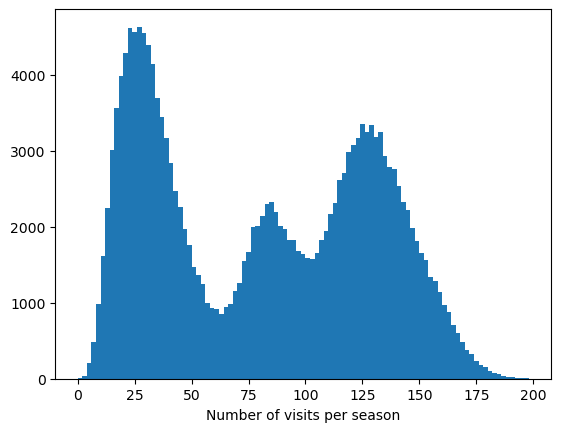

In [21]:
# hackety hack to make a quick histogram of the non-first/last season nvisits values
vals = []
for i in bundle.metric_values.compressed():
    vals.append(i['n_per_season'][1:-1])
vals = np.hstack(vals)
_ = plt.hist(vals, bins=np.arange(0, 200, 2))
plt.xlabel("Number of visits per season")

Text(0.5, 0, 'Season lengths per season (nights)')

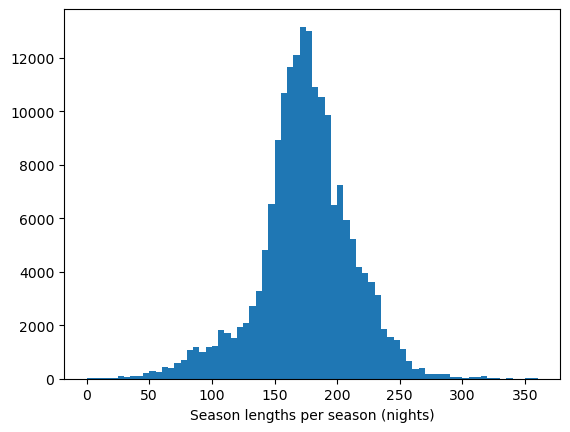

In [22]:
# And the same for the season length, since I didn't even send that anywhere else
vals = []
for i in bundle.metric_values.compressed():
    vals.append(i['season_length'][1:-1])
vals = np.hstack(vals)
_ = plt.hist(vals, bins=np.arange(0, 365, 5))
plt.xlabel("Season lengths per season (nights)")

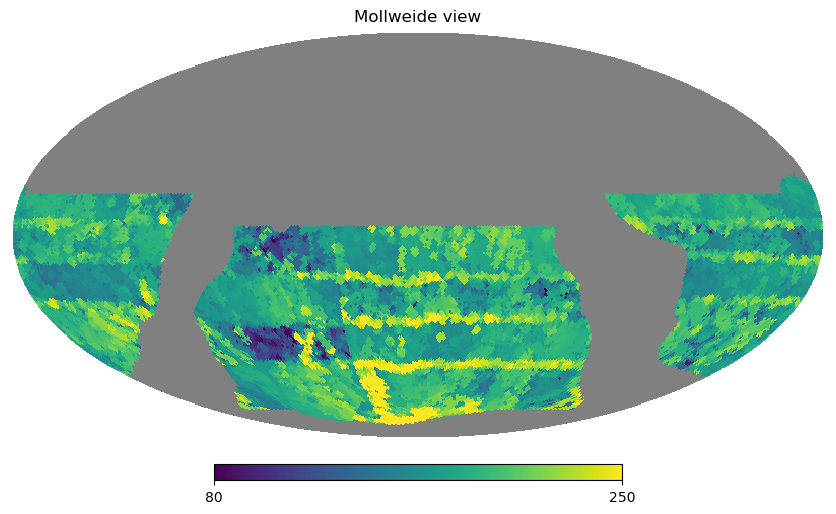

In [24]:
# I'm curious about the season length over the sky, say in the middle of the survey
# is good that the rolling (active/inactive) doesn't strongly impact season length
# I'm not so sure about why the boundaries between regions have such long seasons ..
vals = []
for i in bundle.metric_values.filled(0):
    if i == 0:
        vals.append(hp.UNSEEN)
    else:
        idx = np.where(i['season_id'] == 6)[0]
        if len(idx) == 0:
            vals.append(hp.UNSEEN)
        else:
            vals.append(i['season_length'][idx][0])
vals = np.array(vals)
hp.mollview(vals, min=80, max=250)

{'SkyMap': <Figure size 640x480 with 2 Axes>}

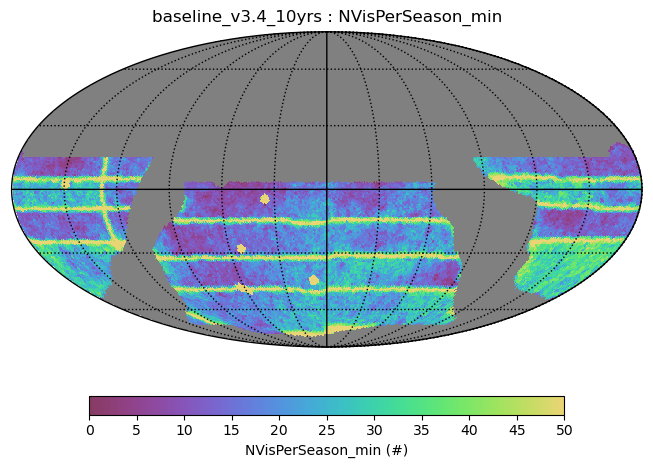

In [26]:
# This is just a standard metric bundle - minimum number of visits per season
k = 'NVisPerSeason_min'
g.bundle_dict[k].set_plot_dict({'color_min': 0, 'color_max': 50, 'x_min': 0, 'x_max':200})
g.bundle_dict[k].set_plot_funcs([maf.HealpixSkyMap()])
g.bundle_dict[k].plot()
#print(g.bundle_dict[k].summary_values)

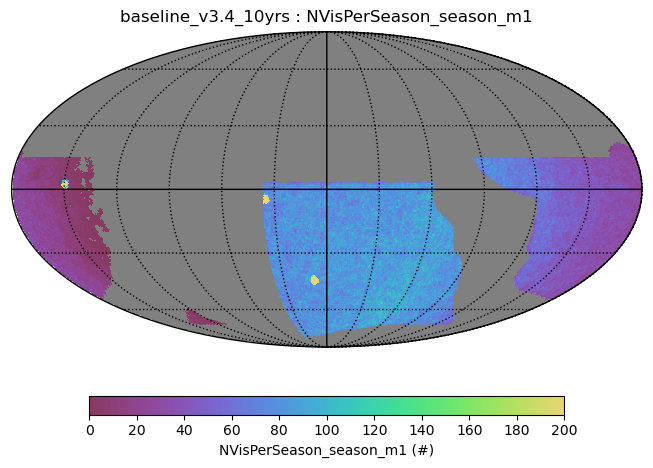

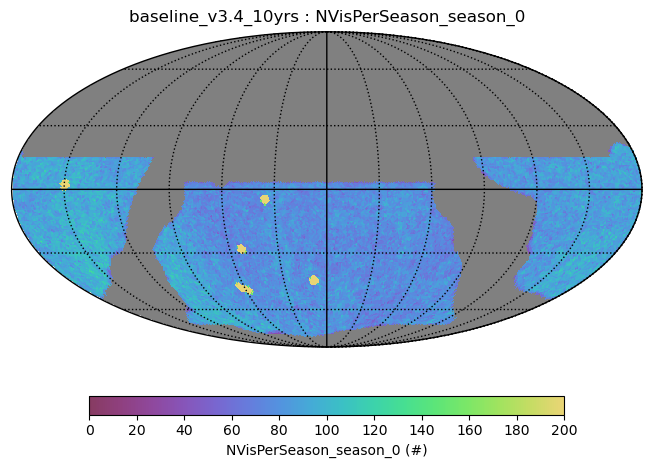

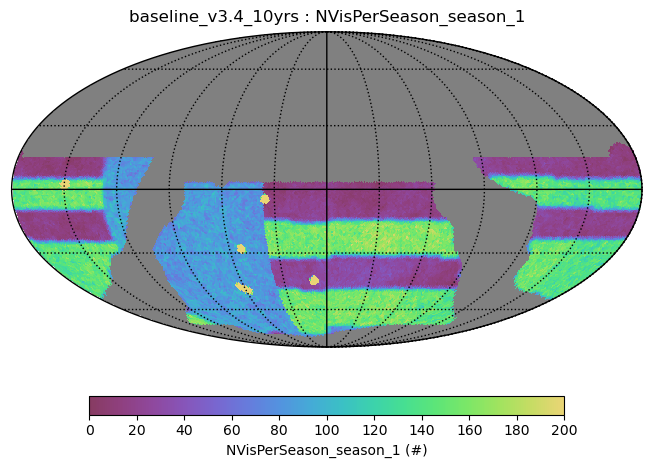

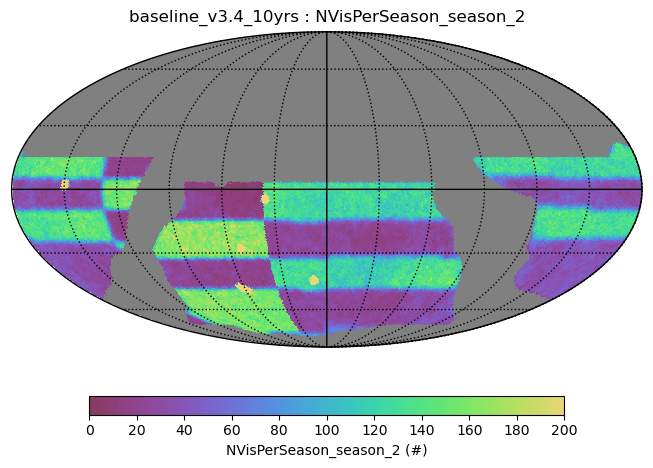

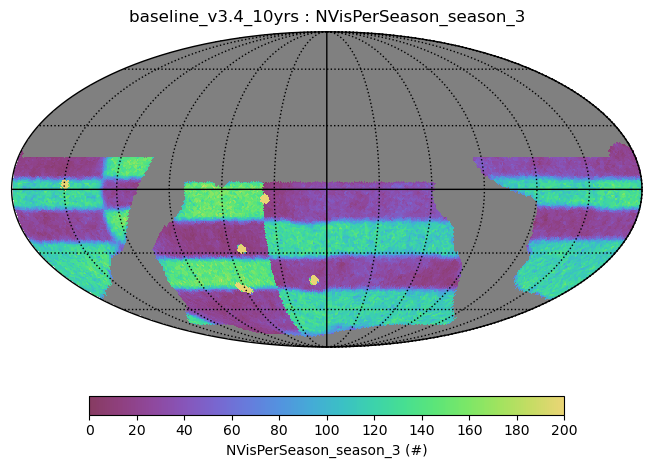

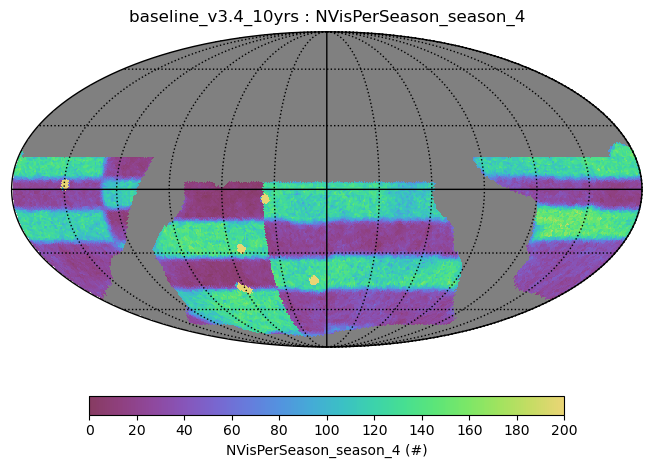

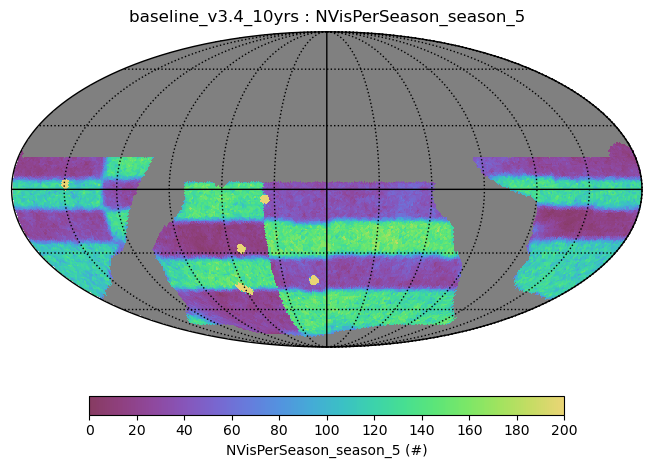

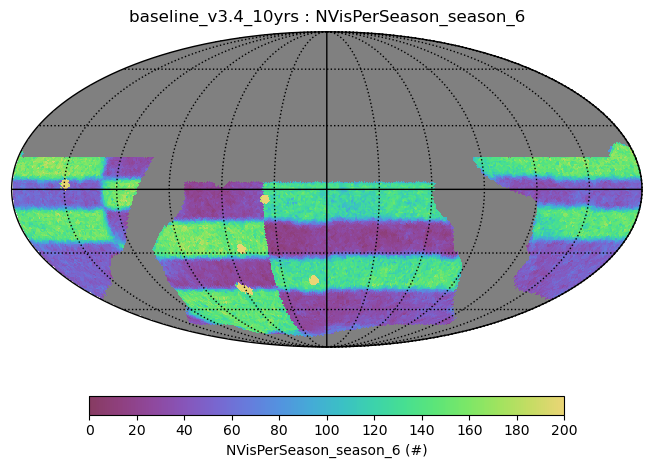

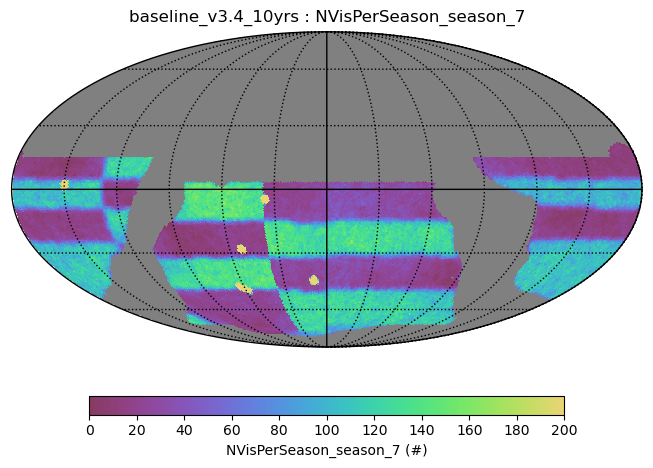

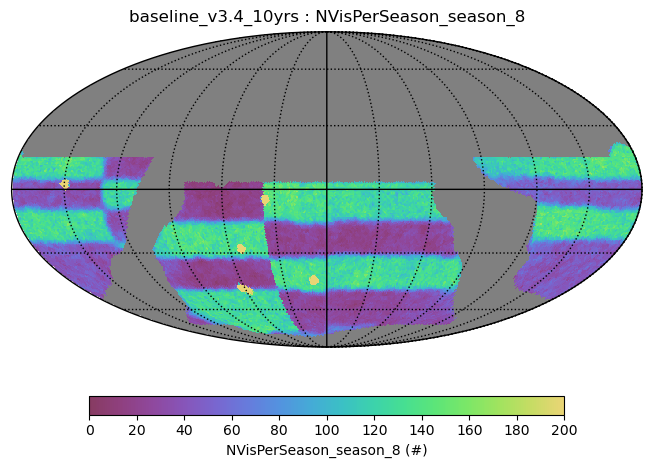

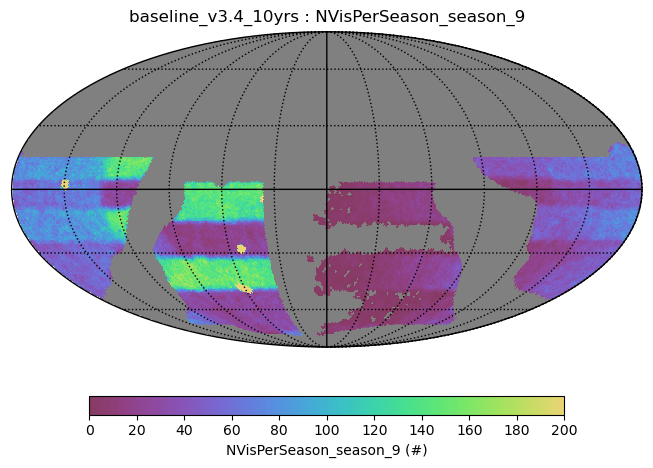

In [27]:
# Plot the visits per season 
for i in ['m1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    k = f'NVisPerSeason_season_{i}'
    g.bundle_dict[k].set_plot_dict({'color_min': 0, 'color_max': 200, 'x_min': 0, 'x_max':200})
    g.bundle_dict[k].set_plot_funcs([maf.HealpixSkyMap()])
    g.bundle_dict[k].plot()

In [28]:
# Repeat for the roll uniform simulation
opsim_fname = 'roll_uniform_early_half_mjdp0_v3.4_10yrs.db'
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

bundle2 = maf.MetricBundle(mymetric, wfd_slicer, None, run_name=runName, summary_metrics=summary_metrics)

roll_uniform_early_half_mjdp0_v3.4_10yrs.db
roll_uniform_early_half_mjdp0_v3.4_10yrs


In [29]:
g2 = maf.MetricBundleGroup({'test_metric': bundle2}, opsim_fname, out_dir='test', results_db=None, verbose=True)
# And calculate the metric
g2.run_all()

Querying table None with no constraint for columns ['rotSkyPos', 'visitExposureTime', 'observationStartMJD', 'fieldDec', 'fieldRA'].
Found 2145777 visits
Running:  ['test_metric']
Processing slices:  44%|███████         | 21580/49152 [01:47<02:17, 199.81it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Text(0.5, 0, 'Number of visits per season')

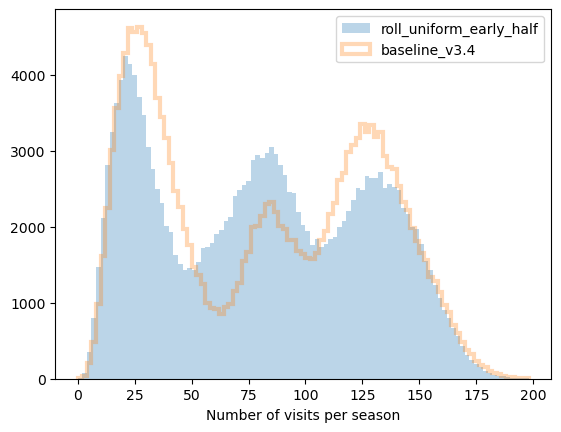

In [30]:
vals = []
for i in bundle2.metric_values.compressed():
    vals.append(i['n_per_season'][1:-1])
vals = np.hstack(vals)
_ = plt.hist(vals, bins=np.arange(0, 200, 2), alpha=0.3, label='roll_uniform_early_half')

vals = []
for i in bundle.metric_values.compressed():
    vals.append(i['n_per_season'][1:-1])
vals = np.hstack(vals)
_ = plt.hist(vals, bins=np.arange(0, 200, 2), alpha=0.3, label='baseline_v3.4', histtype='step', linewidth=3)
plt.legend()
plt.xlabel("Number of visits per season")

Text(0.5, 0, 'Season length per season')

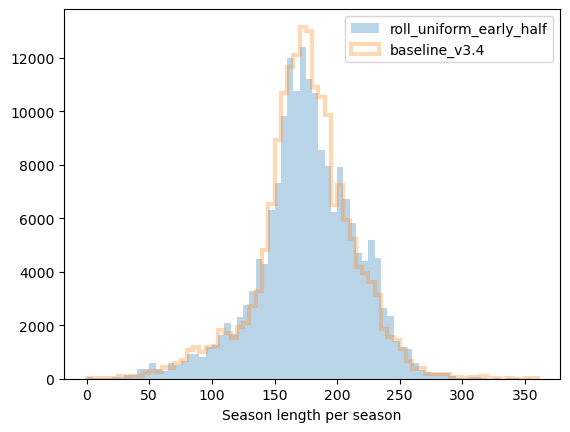

In [31]:
vals = []
for i in bundle2.metric_values.compressed():
    vals.append(i['season_length'][1:-1])
vals = np.hstack(vals)
_ = plt.hist(vals, bins=np.arange(0, 365, 5), alpha=0.3, label='roll_uniform_early_half')

vals = []
for i in bundle.metric_values.compressed():
    vals.append(i['season_length'][1:-1])
vals = np.hstack(vals)
_ = plt.hist(vals, bins=np.arange(0, 365, 5), alpha=0.3, label='baseline_v3.4', histtype='step', linewidth=3)
plt.legend()
plt.xlabel("Season length per season")

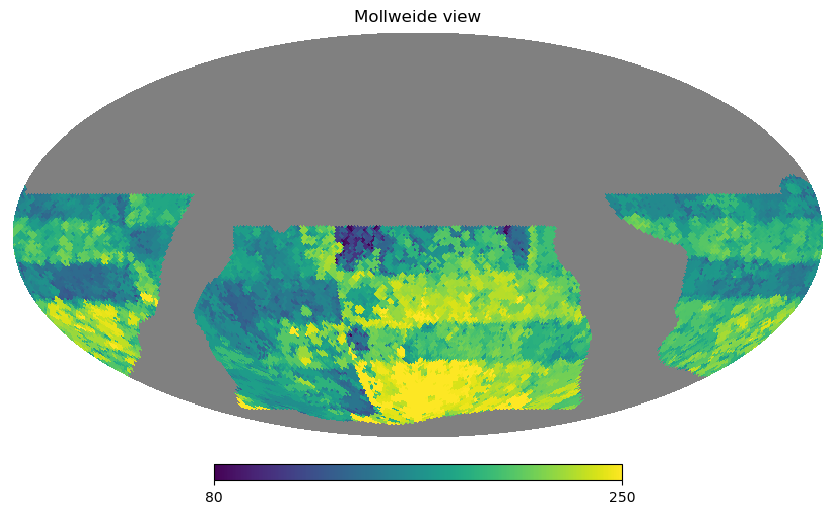

In [35]:
# Hmm. So this was to look at season length in the middle of the survey again, in a given season .. 
# but I really don't understand why some of these places on the sky have such long seasons now.
vals = []
for i in bundle2.metric_values.filled(0):
    if i == 0:
        vals.append(hp.UNSEEN)
    else:
        idx = np.where(i['season_id'] == 6)[0]
        if len(idx) == 0:
            vals.append(hp.UNSEEN)
        else:
            vals.append(i['season_length'][idx][0])
vals = np.array(vals)
hp.mollview(vals, min=80, max=250)

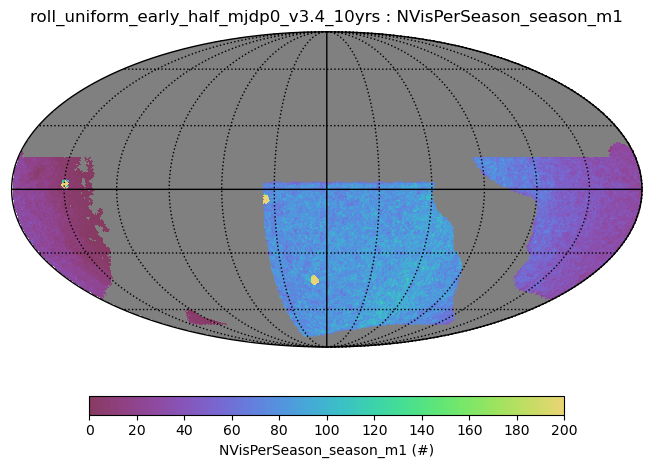

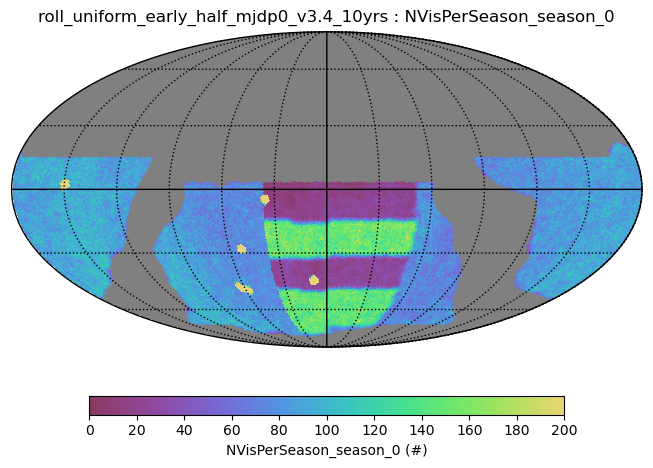

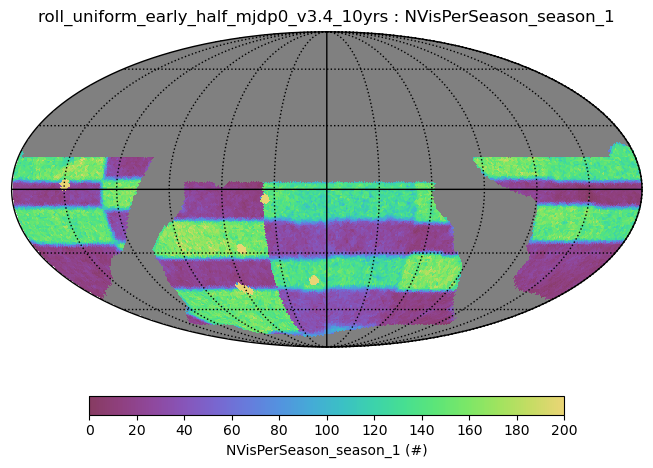

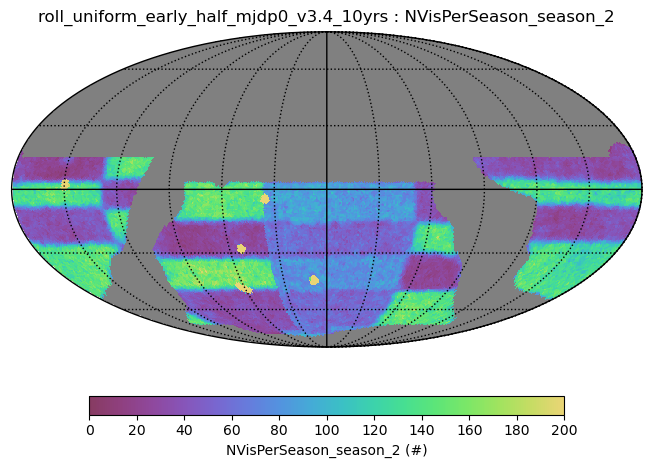

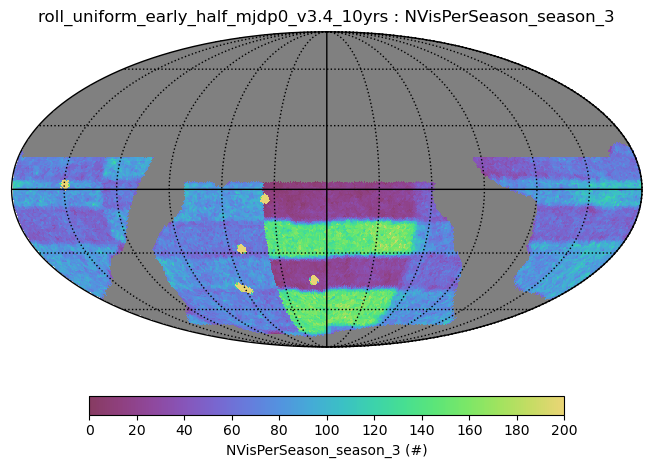

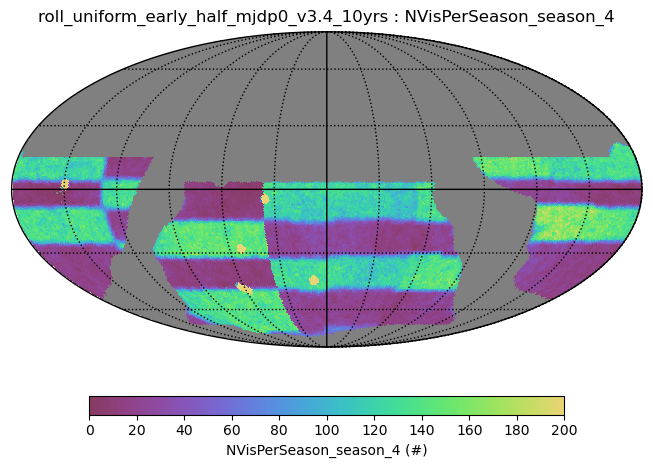

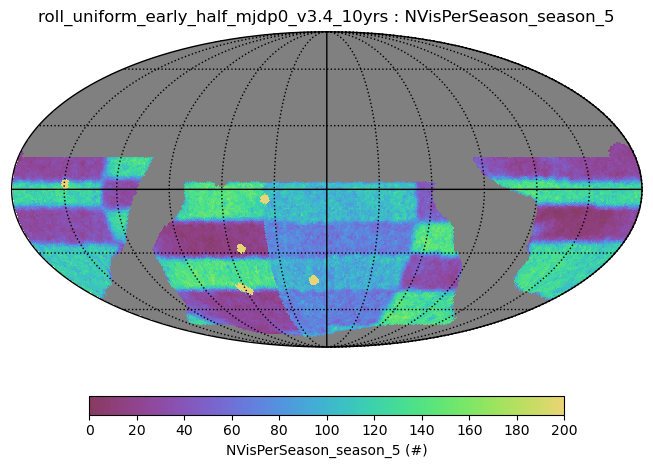

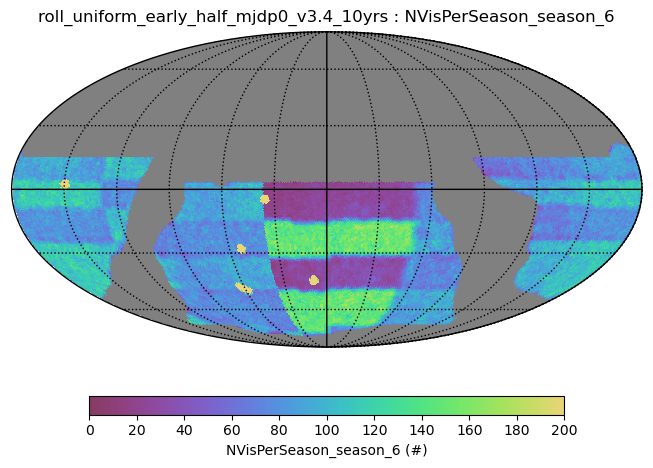

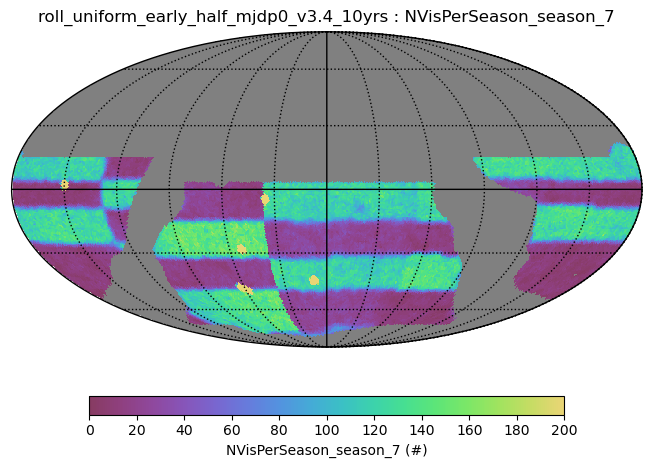

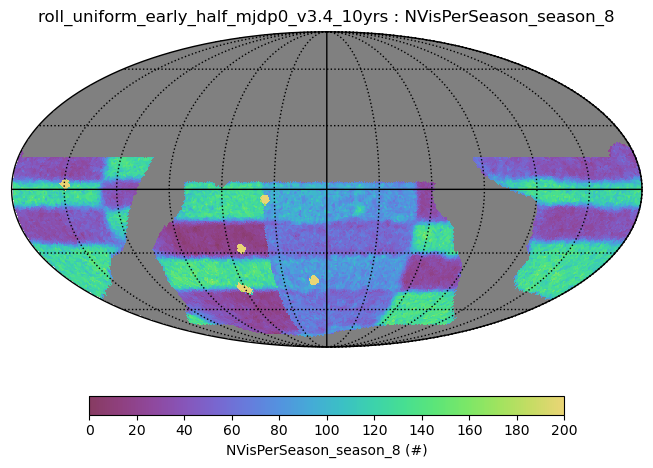

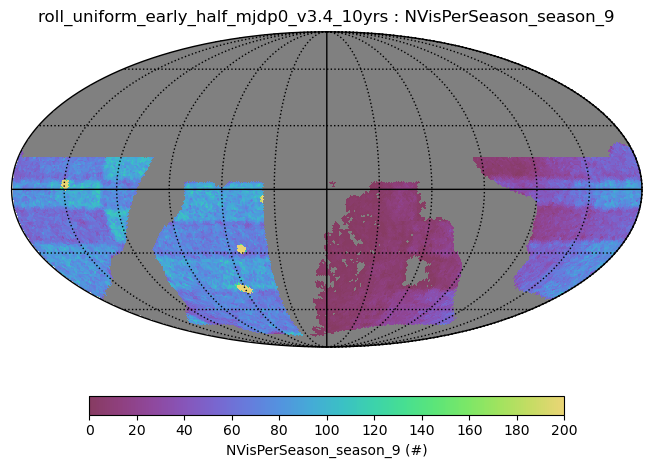

In [37]:
for i in ['m1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
    k = f'NVisPerSeason_season_{i}'
    g2.bundle_dict[k].set_plot_dict({'color_min': 0, 'color_max': 200, 'x_min': 0, 'x_max':200})
    g2.bundle_dict[k].set_plot_funcs([maf.HealpixSkyMap()])
    g2.bundle_dict[k].plot()

In [38]:
# Make a nice table of median min per season and max per season visit values 
k = ['NVisPerSeason_min', 'NVisPerSeason_max']
pd.DataFrame([[g.bundle_dict[k[0]].summary_values['Median'], 
               g2.bundle_dict[k[0]].summary_values['Median']], 
              [g.bundle_dict[k[1]].summary_values['Median'], 
               g2.bundle_dict[k[1]].summary_values['Median']]],
            columns=['baseline_v3.4_10yrs', 'roll_uniform_early_half_mjdp0_v3.4_10yrs', ],
            index=['min', 'max']).T

min    max
baseline_v3.4_10yrs                       21.0  148.0
roll_uniform_early_half_mjdp0_v3.4_10yrs  20.0  145.0

In [55]:
# Just a little side track to visualize season values over the sky at the start of the survey


def get_sun_radec_at_mjd(mjd):
    t = Time(mjd, format='mjd', location=RUBIN_LOC)
    return get_sun(t).ra.deg, get_sun(t).dec.deg

mjd_start = survey_start_mjd()
mjd = mjd_start
season_start = calc_season(np.degrees(wfd_slicer.slice_points['ra']), [mjd], mjd_start).flatten()
sun_ra_start, sun_dec_start = get_sun_radec_at_mjd(mjd)
mjd = mjd + 6 * 30
season_plus = calc_season(np.degrees(wfd_slicer.slice_points['ra']), [mjd], mjd_start).flatten()
sun_ra_plus, sun_dec_plus = get_sun_radec_at_mjd(mjd)
print(sun_ra_start, sun_dec_start, sun_ra_plus, sun_dec_plus)

38.10788895153141 14.977022773556673 212.19992785705352 -13.006618390187795


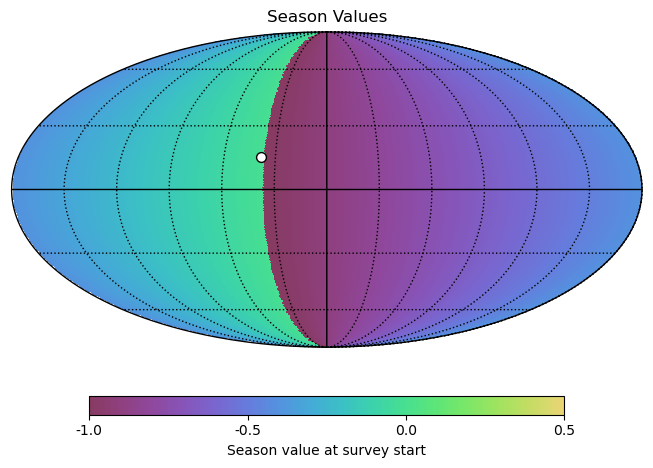

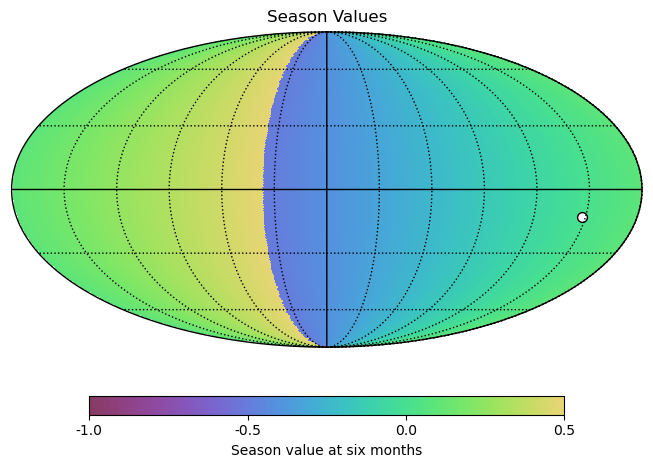

In [56]:
# it's not well marked (sorry), but the graticules are spaced by 30 degree in RA -- 0 is at the center,
# then RA increases to the left, reaching 180 at the left edge (mirrors to the right edge) and then continues

bb = maf.create_empty_metric_bundle()
bb.slicer = wfd_slicer
bb.metric = maf.CountMetric()
bb._setup_metric_values()
bb.set_plot_funcs([maf.HealpixSkyMap()])
bb.set_plot_dict({'xlabel': "Season value at survey start", 'title': "Season Values", "n_ticks": 3,
                  'cbar_format': "%.1f",
                 'color_min': -1, 'color_max': 0.5})
bb.metric_values[:] = season_start
dd = bb.plot()
fig = dd['SkyMap']
ll = hp.projscatter(
                    sun_ra_start,
                    sun_dec_start,
                    color="white",
                    edgecolor="k",
                    marker="o",
                    s=50,
                    lonlat=True,
                    label="Sun",
                )


bb.set_plot_dict({'xlabel': "Season value at six months", 'title': "Season Values", "n_ticks": 3,
                  'cbar_format': "%.1f",
                 'color_min': -1, 'color_max': 0.5})
bb.metric_values[:] = season_plus
dd = bb.plot()
fig = dd['SkyMap']
ll = hp.projscatter(
                    sun_ra_plus,
                    sun_dec_plus,
                    color="white",
                    edgecolor="k",
                    marker="o",
                    s=50,
                    lonlat=True,
                    label="Sun",
                )

In [57]:
# Just one double-check ..
g.sim_data['observationStartMJD'].min(), survey_start_mjd()

(60796.00143922635, 60796.0)

In [59]:
# Then I poked at something about season and when things are being observed. ..
sql = 'night > 365 and night < 365+10'
season_min = maf.MetricBundle(SeasonValMetric(reduce_func=np.min), wfd_slicer, sql)
season_mean = maf.MetricBundle(SeasonValMetric(reduce_func=np.mean), wfd_slicer, sql)
season_max = maf.MetricBundle(SeasonValMetric(reduce_func=np.max), wfd_slicer, sql)
season_length = maf.MetricBundle(maf.SeasonLengthMetric(reduce_func=np.max), wfd_slicer, sql)
g3 = maf.MetricBundleGroup({'0': season_min, '1': season_mean, '2': season_max, '3': season_length}, opsim_fname, out_dir='test')
g3.run_all()

/Users/lynnej/miniconda3/envs/rubin-sim/lib/python3.11/site-packages/skyproj/_skyproj.py:937: FutureWarning: Usage of set_xlabel on a skyproj map has been deprecated. Please use sp.ax.set_xlabel() instead.
  warnings.warn("Usage of set_xlabel on a skyproj map has been deprecated. "
/Users/lynnej/miniconda3/envs/rubin-sim/lib/python3.11/site-packages/skyproj/_skyproj.py:955: FutureWarning: Usage of set_ylabel on a skyproj map has been deprecated. Please use sp.ax.set_ylabel() instead.
  warnings.warn("Usage of set_ylabel on a skyproj map has been deprecated. "


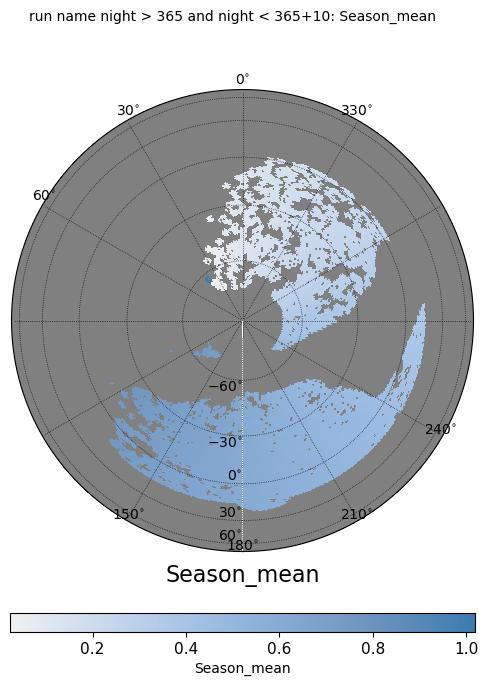

In [60]:
# We can do this now .. new plotters 

ph = maf.PlotHandler(thumbnail=False, out_dir='test')
# Offset center very slightly from s pole so longitude is well defined.
tiny_angle = np.degrees(np.arccos(np.finfo(float).resolution))
plot_dict = {
    "skyproj": skyproj.LaeaSkyproj,
    "skyproj_kwargs": {'lat_0': -tiny_angle, 'lon_0': 0},
    #'model_observatory': model_observatory,
    'cmap': colorcet.cm['blues'],
    'decorations': ['colorbar'],
    'figsize': (8, 8),
}

ph.set_metric_bundles([season_mean])
plotter = maf.plots.skyproj_plotters.HpxmapPlotter()

fig = ph.plot(plotter, plot_dicts=plot_dict)

{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

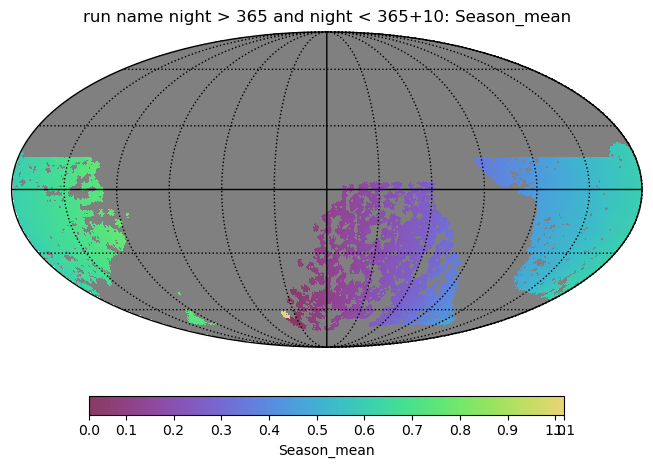

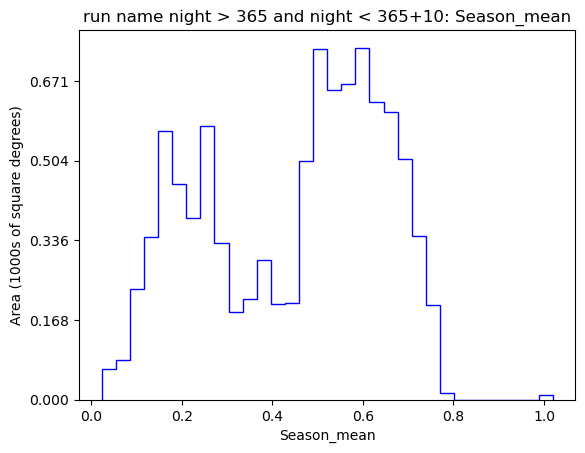

In [61]:
season_mean.plot()

In [62]:
# wow I should check into that visit being observed so close to season = 1.0 ... 

In [ ]:
nvisits = {}
for opsim in ['v3.0', 'v3.3', 'v3.4']:
    sql = 'visitExposureTime > 18 and note not like "%DD%"'
    nvisits[opsim] = maf.MetricBundle(maf.CountMetric('observationStartMJD'), wfd_slicer, sql, run_name=opsim, info_label="standard WFD")
    opsdb = f'../baseline_{opsim}_10yrs.db'
    gg = maf.MetricBundleGroup({'nvis': nvisits[opsim]}, opsdb, out_dir='test', verbose=True)
    gg.run_all()

In [ ]:
ph.set_metric_bundles([nvisits['v3.4']])
fig = ph.plot(maf.HealpixSkyMap(), plot_dicts={'color_min':500, 'color_max':1000})